In [ ]:
import os
import re
import json
import pandas as pd
import asyncio
from mistralai import Mistral
import nest_asyncio
import config
from tqdm.notebook import tqdm

# ── PATCH JUPYTER ASYNC LOOP ───────────────────────────────────────────────────
nest_asyncio.apply()

# ── CONFIG ─────────────────────────────────────────────────────────────────────
MODEL_NAME = "mistral-medium-latest"  # or "pixtral-12b-latest"
INPUT_CSV = r"D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/flattened_ads_processed.csv"
OUTPUT_CSV = rf"D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/flattened_ads_processed_{MODEL_NAME}.csv"
OUTPUT_JSON_DIR = rf"D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/ai_inference_{MODEL_NAME}"
os.makedirs(OUTPUT_JSON_DIR, exist_ok=True)
RATE_LIMIT = 1  # requests per second

# ── SETUP CLIENT ────────────────────────────────────────────────────────────────
api_key = config.FSP2025
if not api_key:
    raise RuntimeError("Please set MISTRAL_API_KEY in your config")
client = Mistral(api_key=api_key)

# ── LOAD DATA ─────────────────────────────────────────────────────────────────
df = pd.read_csv(INPUT_CSV, dtype=str).fillna("")
# Optional: 
# df = df.head(3)  # for quick tests

# Add notes/model columns
df['ai_notes'] = None
df['ai_model'] = MODEL_NAME

# ── DEFINE PROMPT TEMPLATE ─────────────────────────────────────────────────────
def build_prompt(ad_id, name, bio, image_url):
    return f"""
id: {ad_id}
Name: {name}
Bio: {bio}
Image URL: {image_url}

Instruction:
From the image, bio, and name, extract and estimate the following attributes and return them in **JSON format only**. Do not include explanations outside of the JSON.
The JSON should include **atomic values only** (no long sentences or justifications), except in the "notes" field.
Each field should also include a corresponding "<field_name>_confidence" (value between 0 and 1), reflecting the confidence level of that specific value. Use 0.3 if uncertain and 0.0 if not found.

Additionally, provide an "anonymized_bio" version (in the original language) that removes personally identifiable information (like name, age, location, school/university name, etc.).

Here is the expected JSON structure (you must follow this strictly):

{{
  "id": "xxx",
  "age": , // dont leave empty, estimate from image. if the image is not clear or found and put confidence 0.1
  "age_confidence": ,
  "age_estimate_source": "",  // ("bio", "image", "name")
  "gender": "",
  "gender_confidence": ,
  "Nationality": "",  // (e.g., "French", "American", "Spanish")
  "Nationality_confidence": ,
  "demographic_infos": ["", ""..], // empty array if none
  "demographic_infos_confidence": ,
  "ethnic_origin": "",
  "ethnic_origin_confidence": ,  
  "skin_color": "", // (e.g., "very light", "light", "medium", "brown", "dark", "very dark")
  "skin_color_confidence": ,
  "hair": "", // (e.g., "black", "brown", "blonde", "red", "gray", "bald")
  "hair_confidence": ,
  "eyes": "", // (e.g., "brown", "blue", "green", "hazel", "black")
  "eyes_confidence": ,
  "education_info": "",  
  "education_info_confidence": ,
  "personal_qualities": ["", "", ""], // empty array if none
  "personal_qualities_confidence": ,
  "personal_interests": ["", "", ""], // empty array if none
  "personal_interests_confidence": ,
  "hobbies": ["", ""..], // empty array if none
  "hobbies_confidence": ,
  "color_grade": "",  // (e.g., "color", "black and white", "sepia")
  "color_grade_confidence": ,
  "image_type": "",  // (e.g., "selfie", "portrait", "candid", "studio photo", "group photo", "landscape", "professional photography")
  "image_type_confidence": ,
  "mood": "",  // (e.g., "smiling", "serious", "neutral", "sad", etc.)
  "mood_confidence": ,
  "environment": "",  // (e.g., "indoor", "outdoor")
  "environment_confidence": ,
  "environment_description": ["", "", ""],
  "environment_description_confidence": ,
  "has_filter": false,  // "image filter" (true or false)
  "has_filter_confidence": ,
  "image_composition": "",  // (e.g., "centered", "diagonal", "rule of thirds", "close-up"...)
  "image_composition_confidence": ,
  "face_visible": false,  // (true or false)
  "face_visible_confidence": ,
  "face_ratio": ,  // size of face in the image, float between 0 and 1
  "face_ratio_confidence": ,
  "other": "", // any intresting information that does not fit in the above categories and relevant to sociological analysis
  "other_confidence": ,
  "anonymized_bio": "",
  "notes": "" // notes about the extraction process, any issues, or additional context
}}

Requirements:
- Priority of extraction source is the description "bio", then if info not present (ethnic_origin, physical attributes..) try estimate from the image.
- Output **only** the JSON (no extra formatting or markdown).
- All fields are required. If the data cannot be extracted, fill with "" or `false` and set confidence to 0.0.
- Keep values simple, discrete, and standardized.
- Ethnic origin from the image if not present in bio.
"""

# ── ASYNC PROCESSING FUNCTION ─────────────────────────────────────────────────
async def process_row(idx, row, delay):
    await asyncio.sleep(delay)
    ad_id = row['ad_id']
    name = row['user_firstName']
    bio = row['ad_content'].replace("/n", " ")
    img = row['user_photos_extra_large']

    prompt = build_prompt(ad_id, name, bio, img)
    raw = ""
    try:
        resp = await asyncio.to_thread(
            client.chat.complete,
            model=MODEL_NAME,
            messages=[{'role':'system','content':''},{'role': 'user', 'content': prompt}],
            max_tokens=1800,
            temperature=0.0
        )
        raw = resp.choices[0].message.content.strip()
        # strip fences
        text = re.sub(r'^```(?:json)?/n', '', raw)
        text = re.sub(r'/n```$', '', text)
        data = json.loads(text)
        # save JSON
        json_path = os.path.join(OUTPUT_JSON_DIR, f"{ad_id}.json")
        with open(json_path, 'w', encoding='utf-8') as jf:
            json.dump(data, jf, ensure_ascii=False, indent=2)
    except json.JSONDecodeError as e:
        df.at[idx, 'ai_notes'] = f"JSON decode error: {e} | Raw start: {raw[:100]}"
        return
    except Exception as e:
        df.at[idx, 'ai_notes'] = f"Error: {e}"
        return

    # no need to unpack into df; JSON files hold full data
# ── MAIN EXECUTION ─────────────────────────────────────────────────────────────
async def main():
    tasks = []
    interval = 1.0 / RATE_LIMIT
    for idx, row in df.iterrows():
        tasks.append(asyncio.create_task(process_row(idx, row, idx * interval)))

    pbar = tqdm(total=len(tasks), desc="Profiles processed")
    for coro in asyncio.as_completed(tasks):
        await coro
        pbar.update(1)
    pbar.close()

    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved augmented CSV to: {OUTPUT_CSV}")

# ── RUN ───────────────────────────────────────────────────────────────────────
await main()


Profiles processed:   0%|          | 0/49205 [00:00<?, ?it/s]

Saved augmented CSV to: D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/flattened_ads_processed_mistral-medium-latest.csv


In [ ]:
import os
import re
import json
import pandas as pd
import asyncio
from mistralai import Mistral
import nest_asyncio
import config
from tqdm.notebook import tqdm

# ── PATCH JUPYTER ASYNC LOOP ───────────────────────────────────────────────────
nest_asyncio.apply()

# ── CONFIG ─────────────────────────────────────────────────────────────────────
MODEL_NAME = "pixtral-12b-latest" #"mistral-medium-latest"  # or "pixtral-12b-latest"
INPUT_CSV = r"D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/flattened_ads_processed.csv"
OUTPUT_CSV = rf"D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/flattened_ads_processed_{MODEL_NAME}.csv"
OUTPUT_JSON_DIR = rf"D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/ai_inference_{MODEL_NAME}"
os.makedirs(OUTPUT_JSON_DIR, exist_ok=True)
RATE_LIMIT = 0.95 # requests per second

# ── SETUP CLIENT ────────────────────────────────────────────────────────────────
api_key = config.FSP2025
if not api_key:
    raise RuntimeError("Please set MISTRAL_API_KEY in your config")
client = Mistral(api_key=api_key)

# ── LOAD DATA ─────────────────────────────────────────────────────────────────
df = pd.read_csv(INPUT_CSV, dtype=str).fillna("")
# Optional: 
# df = df.head(3)  # for quick tests

# Add notes/model columns
df['ai_notes'] = None
df['ai_model'] = MODEL_NAME

# ── DEFINE PROMPT TEMPLATE ─────────────────────────────────────────────────────
def build_prompt(ad_id, name, bio, image_url):
    return f"""
id: {ad_id}
Name: {name}
Bio: {bio}
Image URL: {image_url}

Instruction:
From the image, bio, and name, extract and estimate the following attributes and return them in **JSON format only**. Do not include explanations outside of the JSON.
The JSON should include **atomic values only** (no long sentences or justifications), except in the "notes" field.
Each field should also include a corresponding "<field_name>_confidence" (value between 0 and 1), reflecting the confidence level of that specific value. Use 0.3 if uncertain and 0.0 if not found.

Additionally, provide an "anonymized_bio" version (in the original language) that removes personally identifiable information (like name, age, location, school/university name, etc.).

Here is the expected JSON structure (you must follow this strictly):

{{
  "id": "xxx",
  "age": , // dont leave empty, estimate from image. if the image is not clear or found and put confidence 0.1
  "age_confidence": ,
  "age_estimate_source": "",  // ("bio", "image", "name")
  "gender": "",
  "gender_confidence": ,
  "Nationality": "",  // (e.g., "French", "American", "Spanish")
  "Nationality_confidence": ,
  "demographic_infos": ["", ""..], // empty array if none
  "demographic_infos_confidence": ,
  "ethnic_origin": "",
  "ethnic_origin_confidence": ,  
  "skin_color": "", // (e.g., "very light", "light", "medium", "brown", "dark", "very dark")
  "skin_color_confidence": ,
  "hair": "", // (e.g., "black", "brown", "blonde", "red", "gray", "bald")
  "hair_confidence": ,
  "eyes": "", // (e.g., "brown", "blue", "green", "hazel", "black")
  "eyes_confidence": ,
  "education_info": "",  
  "education_info_confidence": ,
  "personal_qualities": ["", "", ""], // empty array if none
  "personal_qualities_confidence": ,
  "personal_interests": ["", "", ""], // empty array if none
  "personal_interests_confidence": ,
  "hobbies": ["", ""..], // empty array if none
  "hobbies_confidence": ,
  "color_grade": "",  // (e.g., "color", "black and white", "sepia")
  "color_grade_confidence": ,
  "image_type": "",  // (e.g., "selfie", "portrait", "candid", "studio photo", "group photo", "landscape", "professional photography")
  "image_type_confidence": ,
  "mood": "",  // (e.g., "smiling", "serious", "neutral", "sad", etc.)
  "mood_confidence": ,
  "environment": "",  // (e.g., "indoor", "outdoor")
  "environment_confidence": ,
  "environment_description": ["", "", ""],
  "environment_description_confidence": ,
  "has_filter": false,  // "image filter" (true or false)
  "has_filter_confidence": ,
  "image_composition": "",  // (e.g., "centered", "diagonal", "rule of thirds", "close-up"...)
  "image_composition_confidence": ,
  "face_visible": false,  // (true or false)
  "face_visible_confidence": ,
  "face_ratio": ,  // size of face in the image, float between 0 and 1
  "face_ratio_confidence": ,
  "other": "", // any intresting information that does not fit in the above categories and relevant to sociological analysis
  "other_confidence": ,
  "anonymized_bio": "",
  "notes": "" // notes about the extraction process, any issues, or additional context
}}

Requirements:
- Priority of extraction source is the description "bio", then if info not present (ethnic_origin, physical attributes..) try estimate from the image.
- Output **only** the JSON (no extra formatting or markdown).
- All fields are required. If the data cannot be extracted, fill with "" or `false` and set confidence to 0.0.
- Keep values simple, discrete, and standardized.
- Ethnic origin from the image if not present in bio.
"""

# ── ASYNC PROCESSING FUNCTION ─────────────────────────────────────────────────
async def process_row(idx, row, delay):
    await asyncio.sleep(delay)
    ad_id = row['ad_id']
    name = row['user_firstName']
    bio = row['ad_content'].replace("\n", " ")
    img = row['user_photos_extra_large']

    prompt = build_prompt(ad_id, name, bio, img)
    raw = ""
    try:
        resp = await asyncio.to_thread(
            client.chat.complete,
            model=MODEL_NAME,
            messages=[{'role':'system','content':''},{'role': 'user', 'content': prompt}],
            max_tokens=2000,
            temperature=0.0
        )
        raw = resp.choices[0].message.content.strip()
        # strip fences
        text = re.sub(r'^```(?:json)?\n', '', raw)
        text = re.sub(r'\n```$', '', text)
        data = json.loads(text)
        # save JSON
        json_path = os.path.join(OUTPUT_JSON_DIR, f"{ad_id}.json")
        with open(json_path, 'w', encoding='utf-8') as jf:
            json.dump(data, jf, ensure_ascii=False, indent=2)
    except json.JSONDecodeError as e:
        df.at[idx, 'ai_notes'] = f"JSON decode error: {e} | Raw start: {raw[:100]}"
        return
    except Exception as e:
        df.at[idx, 'ai_notes'] = f"Error: {e}"
        return

    # no need to unpack into df; JSON files hold full data
# ── MAIN EXECUTION ─────────────────────────────────────────────────────────────
async def main():
    tasks = []
    interval = 1.0 / RATE_LIMIT
    for idx, row in df.iterrows():
        tasks.append(asyncio.create_task(process_row(idx, row, idx * interval)))

    pbar = tqdm(total=len(tasks), desc="Profiles processed")
    for coro in asyncio.as_completed(tasks):
        await coro
        pbar.update(1)
    pbar.close()

    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved augmented CSV to: {OUTPUT_CSV}")

# ── RUN ───────────────────────────────────────────────────────────────────────
await main()


Profiles processed:   0%|          | 0/49205 [00:00<?, ?it/s]

Saved augmented CSV to: D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/flattened_ads_processed_pixtral-12b-latest.csv


In [2]:
import os
import json
import pandas as pd
from tqdm.notebook import tqdm

# ── CONFIG ─────────────────────────────────────────────────────────────────────
JSON_DIR = r"D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/ai_inference_mistral-medium-latest"
CSV_REPORT = r"D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/quality_report_mistral-medium-latest.csv"

# Define your expected schema keys
expected_keys = {
    "id": str,
    "age": (int, float),
    "age_confidence": float,
    "age_estimate_source": str,
    "gender": str,
    "gender_confidence": float,
    "Nationality": str,
    "Nationality_confidence": float,
    "demographic_infos": list,
    "demographic_infos_confidence": float,
    "ethnic_origin": str,
    "ethnic_origin_confidence": float,
    "skin_color": str,
    "skin_color_confidence": float,
    "hair": str,
    "hair_confidence": float,
    "eyes": str,
    "eyes_confidence": float,
    "education_info": str,
    "education_info_confidence": float,
    "personal_qualities": list,
    "personal_qualities_confidence": float,
    "personal_interests": list,
    "personal_interests_confidence": float,
    "hobbies": list,
    "hobbies_confidence": float,
    "color_grade": str,
    "color_grade_confidence": float,
    "image_type": str,
    "image_type_confidence": float,
    "mood": str,
    "mood_confidence": float,
    "environment": str,
    "environment_confidence": float,
    "environment_description": list,
    "environment_description_confidence": float,
    "has_filter": bool,
    "has_filter_confidence": float,
    "image_composition": str,
    "image_composition_confidence": float,
    "face_visible": bool,
    "face_visible_confidence": float,
    "face_ratio": float,
    "face_ratio_confidence": float,
    "other": str,
    "other_confidence": float,
    "anonymized_bio": str,
    "notes": str
}

# Prepare report container
rows = []

# Iterate over each JSON file
for fname in tqdm(os.listdir(JSON_DIR)):
    if not fname.endswith(".json"):
        continue
    path = os.path.join(JSON_DIR, fname)
    ad_id = os.path.splitext(fname)[0]
    record = {"ad_id": ad_id, "file": fname}
    
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except Exception as e:
        # Failed to load JSON
        record.update({
            "status": "invalid_json",
            "error": str(e),
            "missing_keys": None,
            "empty_keys": None
        })
        rows.append(record)
        continue
    
    # If API inserted an explicit error flag
    if isinstance(data, dict) and "error" in data:
        record.update({
            "status": "api_error",
            "error": data.get("error"),
            "missing_keys": None,
            "empty_keys": None
        })
        rows.append(record)
        continue
    
    # Validate keys and values
    missing = []
    empty = []
    for key, expected_type in expected_keys.items():
        if key not in data:
            missing.append(key)
        else:
            val = data[key]
            # consider empty if string/list but no content, or None
            if val is None or (isinstance(val, str) and val.strip()=="" ) or (isinstance(val, list) and len(val)==0):
                empty.append(key)
            # optionally: type check
            # if not isinstance(val, expected_type):
            #     record.setdefault("type_mismatch", []).append(key)
    
    record.update({
        "status": "ok" if not missing else "missing_fields",
        "error": None,
        "missing_keys": ";".join(missing) if missing else "",
        "empty_keys": ";".join(empty) if empty else ""
    })
    rows.append(record)

# Build DataFrame and save
report_df = pd.DataFrame(rows)
report_df.to_csv(CSV_REPORT, index=False)

# Show summary
counts = report_df["status"].value_counts()
print("Profile validation status counts:\n", counts)
report_df.head(10)


  0%|          | 0/46379 [00:00<?, ?it/s]

Profile validation status counts:
 status
ok    46379
Name: count, dtype: int64


,ad_id,file,status,error,missing_keys,empty_keys
0,1000537,1000537.json,ok,None,,other
1,10027,10027.json,ok,None,,
2,1002826,1002826.json,ok,None,,demographic_infos;other
3,1003896,1003896.json,ok,None,,demographic_infos;education_info;personal_inte...
4,1004573,1004573.json,ok,None,,demographic_infos;education_info;personal_inte...
5,1004758,1004758.json,ok,None,,education_info;hobbies;other
6,1006334,1006334.json,ok,None,,education_info;other
7,1006360,1006360.json,ok,None,,demographic_infos;education_info;personal_inte...
8,1007088,1007088.json,ok,None,,education_info;other
9,1007753,1007753.json,ok,None,,education_info;hobbies;other


In [3]:
%pip install ace_tools

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


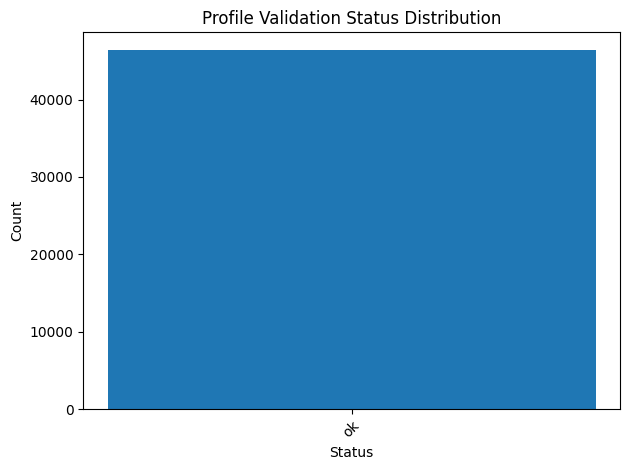

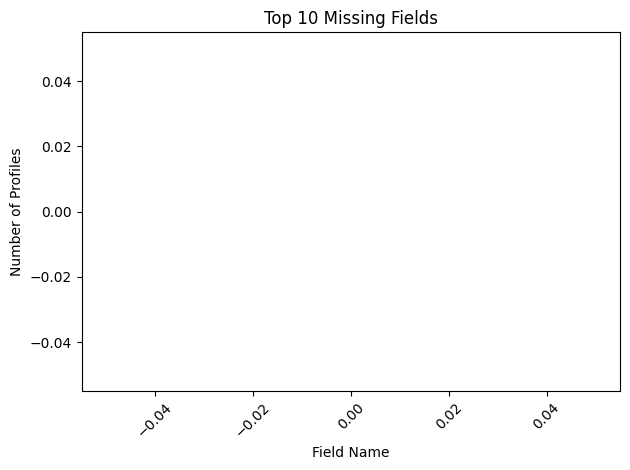

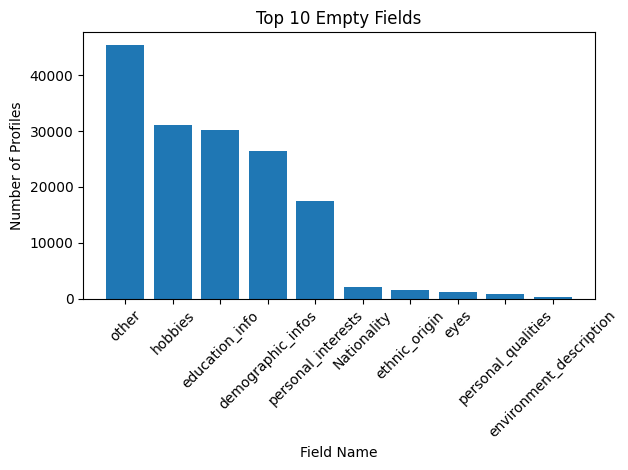

ModuleNotFoundError: No module named 'ace_tools'

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load report
CSV_REPORT = r"D:\Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/quality_report_mistral-medium-latest.csv"
report_df = pd.read_csv(CSV_REPORT)

# 1) Plot status distribution
status_counts = report_df['status'].value_counts()

plt.figure()
plt.bar(status_counts.index, status_counts.values)
plt.title('Profile Validation Status Distribution')
plt.ylabel('Count')
plt.xlabel('Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2) Top missing fields
# Explode missing_keys into individual rows
mk = report_df['missing_keys'].dropna().astype(str)
exploded = mk[mk != ""].str.split(';').explode()
missing_freq = exploded.value_counts().head(10)

plt.figure()
plt.bar(missing_freq.index, missing_freq.values)
plt.title('Top 10 Missing Fields')
plt.ylabel('Number of Profiles')
plt.xlabel('Field Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) Top empty fields
ek = report_df['empty_keys'].dropna().astype(str)
exploded_empty = ek[ek != ""].str.split(';').explode()
empty_freq = exploded_empty.value_counts().head(10)

plt.figure()
plt.bar(empty_freq.index, empty_freq.values)
plt.title('Top 10 Empty Fields')
plt.ylabel('Number of Profiles')
plt.xlabel('Field Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display report summary
import ace_tools as tools; tools.display_dataframe_to_user("Quality Report Sample", report_df.head(20))
